# Forecasting Dublin Bike Availability Using Machine Learning Models



## CA3 Capstone Project Strategic Thinking
### Eliana Hincapie

The primary objective of this project is to develop machine learning models capable of accurately forecasting the availability of bicycles at individual Dublin Bikes stations. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings 

warnings.filterwarnings('ignore')

In [3]:
#Load dataset
df = pd.read_csv('dublin-bikes_station_status_122024.csv')

#### Understanding the Data

In [4]:
#Preview data
df.head()

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,address,lat,lon,region_id,capacity
0,dublin_bikes,2024-12-01 00:05:00,1,22,9,True,True,True,CLARENDON ROW,NaN,Clarendon Row,53.340927,-6.262501,NaN,31
1,dublin_bikes,2024-12-01 00:05:00,101,10,20,True,True,True,KING STREET NORTH,NaN,King Street North,53.350292,-6.273507,NaN,30
2,dublin_bikes,2024-12-01 00:05:00,102,2,38,True,True,True,WESTERN WAY,NaN,Western Way,53.354930,-6.269425,NaN,40
3,dublin_bikes,2024-12-01 00:05:00,103,0,40,True,True,True,GRANGEGORMAN LOWER (SOUTH),NaN,Grangegorman Lower (South),53.354664,-6.278681,NaN,40
4,dublin_bikes,2024-12-01 00:05:00,104,0,40,True,True,True,GRANGEGORMAN LOWER (CENTRAL),NaN,Grangegorman Lower (Central),53.355170,-6.278424,NaN,40


In [5]:
#Basic info and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605009 entries, 0 to 605008
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   system_id            605009 non-null  object 
 1   last_reported        605009 non-null  object 
 2   station_id           605009 non-null  int64  
 3   num_bikes_available  605009 non-null  int64  
 4   num_docks_available  605009 non-null  int64  
 5   is_installed         605009 non-null  bool   
 6   is_renting           605009 non-null  bool   
 7   is_returning         605009 non-null  bool   
 8   name                 605009 non-null  object 
 9   short_name           0 non-null       float64
 10  address              605009 non-null  object 
 11  lat                  605009 non-null  float64
 12  lon                  605009 non-null  float64
 13  region_id            0 non-null       float64
 14  capacity             605009 non-null  int64  
dtypes: bool(3), float

In [6]:
df.shape

(605009, 15)

In [7]:
#Descriptive statistics (numerical)
df.describe()

,station_id,num_bikes_available,num_docks_available,short_name,lat,lon,region_id,capacity
count,605009.000000,605009.000000,605009.00000,0.0,605009.000000,605009.000000,0.0,605009.000000
mean,57.951001,12.308017,19.21137,NaN,53.345457,-6.263820,NaN,31.964569
std,33.974053,9.713911,10.91414,NaN,0.007517,0.017848,NaN,7.441581
min,1.000000,0.000000,0.00000,NaN,53.330090,-6.310015,NaN,16.000000
25%,28.000000,4.000000,11.00000,NaN,53.339764,-6.275071,NaN,29.000000
50%,58.000000,11.000000,19.00000,NaN,53.344604,-6.262501,NaN,30.000000
75%,88.000000,19.000000,27.00000,NaN,53.350292,-6.250900,NaN,40.000000
max,117.000000,40.000000,40.00000,NaN,53.359966,-6.230852,NaN,40.000000


In [8]:
#Missing values
df.isnull().sum()

system_id                   0
last_reported               0
station_id                  0
num_bikes_available         0
num_docks_available         0
is_installed                0
is_renting                  0
is_returning                0
name                        0
short_name             605009
address                     0
lat                         0
lon                         0
region_id              605009
capacity                    0
dtype: int64

In [9]:
#Duplicates
df.duplicated().sum()

0

In [10]:
df['num_bikes_available'].unique()

array([22, 10,  2,  0,  1,  3,  5, 20, 11, 12, 27,  4, 14, 15, 13, 23,  7,
       30,  8, 16,  9, 25, 28, 38, 36, 17, 21,  6, 29, 24, 40, 26, 19, 35,
       18, 31, 32, 34, 33, 37, 39], dtype=int64)

In [11]:
#Group by station and get the maximum capacity (bike_stands)
station_capacity = df.groupby('station_id')['capacity'].max().reset_index()
station_capacity

,station_id,capacity
0,1,31
1,2,20
2,3,20
3,4,20
4,5,40
...,...,...
110,113,40
111,114,40
112,115,30
113,116,30


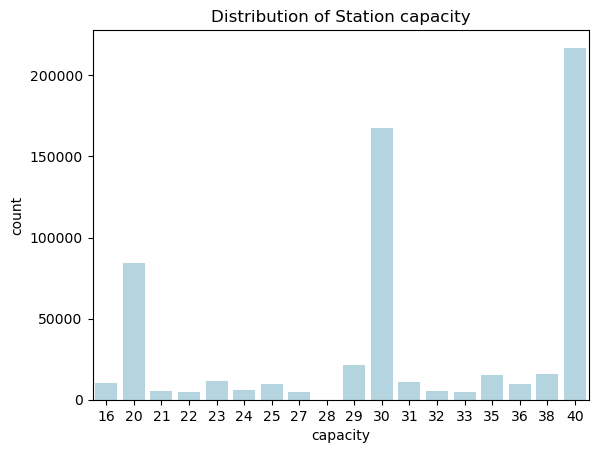

In [12]:
sns.countplot(data=df, x='capacity', color='lightblue')
plt.title('Distribution of Station capacity')
plt.show()

#### Data Preparation

The dataset is large, making the models slow, so we are going to reduce the dataset size sampling it, without losing much predictive power.

In [13]:
#Take a random 10% sample of the dataset (60k rows)
df_sample = df.sample(frac=0.1, random_state=42)

In [14]:
df_sample.shape

(60501, 15)

The missing values are in the 'short_name' and 'region_id' columns, we are going to drop both columns taking into account that null values are 100% for both columns and were not critical for forecasting bike availability.

In [15]:
#Drop specific columns
df_sample = df_sample.drop(columns=['short_name', 'region_id'])

In [16]:
#Confirm Missing values
df_sample.isnull().sum()

system_id              0
last_reported          0
station_id             0
num_bikes_available    0
num_docks_available    0
is_installed           0
is_renting             0
is_returning           0
name                   0
address                0
lat                    0
lon                    0
capacity               0
dtype: int64

With the preview of the data in the understanding process, we can see that can be some attributes that have the same data, which are: system_id, is_installed, is_renting and is_returning.
We are going to check it to define if them are or not useful in our dataset.

In [17]:
df_sample['system_id'].unique()

array(['dublin_bikes'], dtype=object)

In [18]:
df_sample['is_installed'].unique()

array([ True])

In [19]:
df_sample['is_renting'].unique()

array([ True])

In [20]:
df_sample['is_returning'].unique()

array([ True])

Taking into consideration that this attributes have the same value and there are not an important input for our forecast, we are going to drop them all.

In [21]:
#Drop columns
df_sample = df_sample.drop(columns=['system_id', 'is_installed', 'is_renting', 'is_returning'])

In [22]:
#Preview data
df_sample.head()

,last_reported,station_id,num_bikes_available,num_docks_available,name,address,lat,lon,capacity
72054,2024-12-04 13:15:00,62,29,11,LIME STREET,Lime Street,53.346027,-6.243576,40
385529,2024-12-20 06:45:00,83,28,12,EMMET ROAD,Emmet Road,53.340714,-6.308191,40
75591,2024-12-04 17:10:00,43,3,27,PORTOBELLO ROAD,Portobello Road,53.330090,-6.268044,30
558771,2024-12-29 12:10:00,97,19,21,KILMAINHAM GAOL,Kilmainham Gaol,53.342113,-6.310015,40
478893,2024-12-25 03:45:00,94,13,27,HEUSTON STATION (CAR PARK),Heuston Station (Car Park),53.346985,-6.297804,40


In [23]:
df_sample.shape

(60501, 9)

In [24]:
#Convert last_reported to datetime
df_sample['last_reported'] = pd.to_datetime(df_sample['last_reported'])

In [25]:
#Confirm change, Basic info
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60501 entries, 72054 to 281454
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   last_reported        60501 non-null  datetime64[ns]
 1   station_id           60501 non-null  int64         
 2   num_bikes_available  60501 non-null  int64         
 3   num_docks_available  60501 non-null  int64         
 4   name                 60501 non-null  object        
 5   address              60501 non-null  object        
 6   lat                  60501 non-null  float64       
 7   lon                  60501 non-null  float64       
 8   capacity             60501 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 4.6+ MB


In [26]:
#Extract time-based features
df_sample['hour'] = df_sample['last_reported'].dt.hour
df_sample['minute'] = df_sample['last_reported'].dt.minute
df_sample['day_of_week'] = df_sample['last_reported'].dt.dayofweek
df_sample['day'] = df_sample['last_reported'].dt.day
df_sample['month'] = df_sample['last_reported'].dt.month
df_sample['year'] = df_sample['last_reported'].dt.year
df_sample['date'] = df_sample['last_reported'].dt.date 

In [27]:
#Preview data
df_sample.head()

,last_reported,station_id,num_bikes_available,num_docks_available,name,address,lat,lon,capacity,hour,minute,day_of_week,day,month,year,date
72054,2024-12-04 13:15:00,62,29,11,LIME STREET,Lime Street,53.346027,-6.243576,40,13,15,2,4,12,2024,2024-12-04
385529,2024-12-20 06:45:00,83,28,12,EMMET ROAD,Emmet Road,53.340714,-6.308191,40,6,45,4,20,12,2024,2024-12-20
75591,2024-12-04 17:10:00,43,3,27,PORTOBELLO ROAD,Portobello Road,53.330090,-6.268044,30,17,10,2,4,12,2024,2024-12-04
558771,2024-12-29 12:10:00,97,19,21,KILMAINHAM GAOL,Kilmainham Gaol,53.342113,-6.310015,40,12,10,6,29,12,2024,2024-12-29
478893,2024-12-25 03:45:00,94,13,27,HEUSTON STATION (CAR PARK),Heuston Station (Car Park),53.346985,-6.297804,40,3,45,2,25,12,2024,2024-12-25


In [28]:
#Confirm change, Basic info
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60501 entries, 72054 to 281454
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   last_reported        60501 non-null  datetime64[ns]
 1   station_id           60501 non-null  int64         
 2   num_bikes_available  60501 non-null  int64         
 3   num_docks_available  60501 non-null  int64         
 4   name                 60501 non-null  object        
 5   address              60501 non-null  object        
 6   lat                  60501 non-null  float64       
 7   lon                  60501 non-null  float64       
 8   capacity             60501 non-null  int64         
 9   hour                 60501 non-null  int32         
 10  minute               60501 non-null  int32         
 11  day_of_week          60501 non-null  int32         
 12  day                  60501 non-null  int32         
 13  month                60501 non-

The models expect all numeric columns, so we are going to drop non-numerical columns (last_reported, date).

In [29]:
#Drop columns
df_sample = df_sample.drop(columns=['last_reported', 'date'])

In [30]:
#Confirm change, Basic info
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60501 entries, 72054 to 281454
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_id           60501 non-null  int64  
 1   num_bikes_available  60501 non-null  int64  
 2   num_docks_available  60501 non-null  int64  
 3   name                 60501 non-null  object 
 4   address              60501 non-null  object 
 5   lat                  60501 non-null  float64
 6   lon                  60501 non-null  float64
 7   capacity             60501 non-null  int64  
 8   hour                 60501 non-null  int32  
 9   minute               60501 non-null  int32  
 10  day_of_week          60501 non-null  int32  
 11  day                  60501 non-null  int32  
 12  month                60501 non-null  int32  
 13  year                 60501 non-null  int32  
dtypes: float64(2), int32(6), int64(4), object(2)
memory usage: 5.5+ MB


We need that our model interprete correctly our data, so we are going to encode the columns 'station_id', 'name' and 'address'.

In [31]:
#Encode station id
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_sample[['station_id']])

In [32]:
encoded_df_sample = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(['station_id'])
)

In [33]:
#Join with df
df_sample = df_sample.join(encoded_df_sample)

In [34]:
#Encode object columns
le = LabelEncoder()
df_sample['name_encoded'] = le.fit_transform(df_sample['name'])

le = LabelEncoder()
df_sample['address_encoded'] = le.fit_transform(df_sample['address'])

In [35]:
df_sample = df_sample.drop('name', axis=1)

In [36]:
df_sample = df_sample.drop('address', axis=1)

In [37]:
#Final check
df_sample.info()
df_sample.head()

<class 'pandas.core.frame.DataFrame'>
Index: 60501 entries, 72054 to 281454
Columns: 129 entries, station_id to address_encoded
dtypes: float64(117), int32(8), int64(4)
memory usage: 60.2 MB


,station_id,num_bikes_available,num_docks_available,lat,lon,capacity,hour,minute,day_of_week,day,...,station_id_110,station_id_111,station_id_112,station_id_113,station_id_114,station_id_115,station_id_116,station_id_117,name_encoded,address_encoded
72054,62,29,11,53.346027,-6.243576,40,13,15,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,69
385529,83,28,12,53.340714,-6.308191,40,6,45,4,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,26
75591,43,3,27,53.330090,-6.268044,30,17,10,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,92
558771,97,19,21,53.342113,-6.310015,40,12,10,6,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,65
478893,94,13,27,53.346985,-6.297804,40,3,45,2,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,56


In [38]:
#Confirm Missing values
df_sample.isnull().sum()

station_id                 0
num_bikes_available        0
num_docks_available        0
lat                        0
lon                        0
                       ...  
station_id_115         54488
station_id_116         54488
station_id_117         54488
name_encoded               0
address_encoded            0
Length: 129, dtype: int64

In [39]:
df_sample.shape

(60501, 129)

In [40]:
df_sample['station_id_115'].unique()

array([nan,  0.,  1.])

Because in the Encoding process we got null values, we are going to fill with 0 the values that currently have nan, we are going to do this because basically the cells with nan, mean that 'this station is not present'.

In [41]:
#Fill NaN Columns
df_sample.fillna(0, inplace=True)

In [42]:
df_sample['station_id_115'].unique()

array([0., 1.])

In [43]:
#Confirm Missing values
df_sample.isnull().sum()

station_id             0
num_bikes_available    0
num_docks_available    0
lat                    0
lon                    0
                      ..
station_id_115         0
station_id_116         0
station_id_117         0
name_encoded           0
address_encoded        0
Length: 129, dtype: int64

We did the process and confirmed that we do not have null values.

In [44]:
#Percent utilization
df_sample['utilization_pct'] = df_sample['num_bikes_available'] / df_sample['capacity']

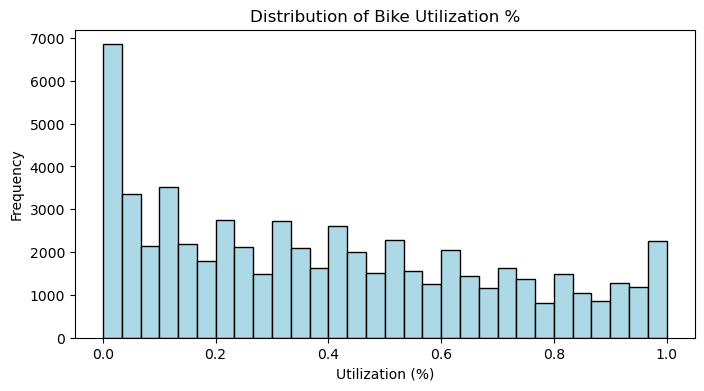

In [45]:
plt.figure(figsize=(8,4))
plt.hist(df_sample['utilization_pct'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Bike Utilization %')
plt.xlabel('Utilization (%)')
plt.ylabel('Frequency')
plt.show()

The histogram shows that Dublin Bikes stations frequently experince both empty (0% utilization) and full (100% utilization) conditions, and how the utilization percentage is distrubuited.

In [46]:
df_sample.head()

,station_id,num_bikes_available,num_docks_available,lat,lon,capacity,hour,minute,day_of_week,day,...,station_id_111,station_id_112,station_id_113,station_id_114,station_id_115,station_id_116,station_id_117,name_encoded,address_encoded,utilization_pct
72054,62,29,11,53.346027,-6.243576,40,13,15,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69,69,0.725
385529,83,28,12,53.340714,-6.308191,40,6,45,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,26,0.700
75591,43,3,27,53.330090,-6.268044,30,17,10,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92,92,0.100
558771,97,19,21,53.342113,-6.310015,40,12,10,6,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65,65,0.475
478893,94,13,27,53.346985,-6.297804,40,3,45,2,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,56,0.325


#### Modeling

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [48]:
#Define X (Features) and y (Target)

# Target
y = df_sample['num_bikes_available']

# Features
feature_cols = ['hour', 'minute', 'day_of_week', 'day', 'capacity', 'station_id']
X = df_sample[feature_cols]

In [49]:
#Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
#Show the rows and columns
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60501, 6), (60501,), (48400, 6), (12101, 6), (48400,), (12101,))

In [51]:
#pip install xgboost

In [52]:
#Import and initialize Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [53]:
#Initialize
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)

In [54]:
#Train Models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [55]:
#Make predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [56]:
def evaluate(model_name, y_test, y_pred):
    print(f"{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
    print("-"*40)

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("Decision Tree", y_test, y_pred_dt)
evaluate("XGBoost", y_test, y_pred_xgb)

Linear Regression Performance:
MAE: 7.85
MSE: 87.71
RMSE: 9.37
R2 Score: 0.0599
----------------------------------------
Random Forest Performance:
MAE: 2.08
MSE: 9.48
RMSE: 3.08
R2 Score: 0.8984
----------------------------------------
Decision Tree Performance:
MAE: 2.07
MSE: 15.16
RMSE: 3.89
R2 Score: 0.8375
----------------------------------------
XGBoost Performance:
MAE: 4.01
MSE: 27.13
RMSE: 5.21
R2 Score: 0.7093
----------------------------------------


The model with better performance is Random Forest, with lower MSE, RMSE and higher R2.

Let's plot the actual values vs the predicted.

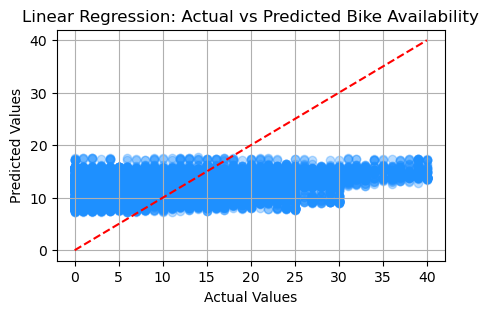

In [57]:
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Bike Availability')
plt.grid(True)
plt.show()

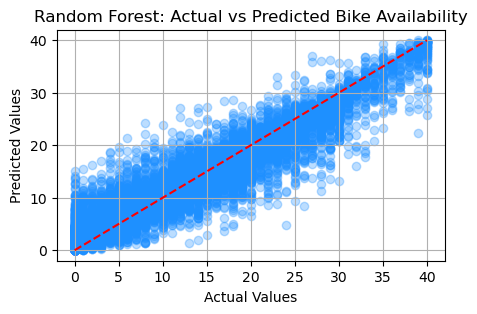

In [58]:
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted Bike Availability")
plt.grid(True)
plt.show()

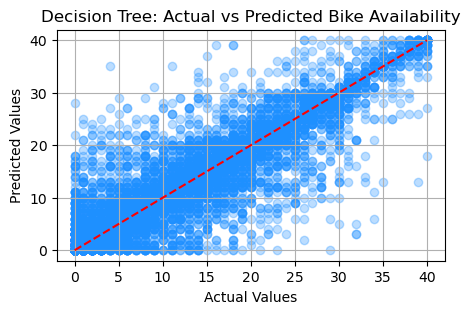

In [59]:
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred_dt, alpha=0.3, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree: Actual vs Predicted Bike Availability')
plt.grid(True)
plt.show()

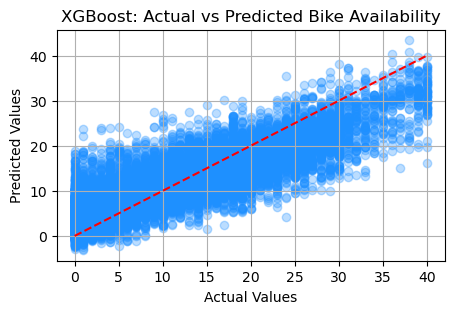

In [60]:
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost: Actual vs Predicted Bike Availability')
plt.grid(True)
plt.show()

#### Hyperparameter tuning and Cross-validation

Linear Regression

In [61]:
lr = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False]
}

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Results
print("Best Linear Regression Params:", grid_search_lr.best_params_)
cv_scores_lr = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (Linear Regression):", -np.mean(cv_scores_lr))

Best Linear Regression Params: {'fit_intercept': False}
Cross-validated MAE (Linear Regression): 7.875893797598683


Random Forest 

In [62]:
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Results
print("Best Random Forest Params:", grid_search_rf.best_params_)
cv_scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (Random Forest):", -np.mean(cv_scores_rf))

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated MAE (Random Forest): 2.376745041322314


Decision Tree

In [63]:
dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Results
print("Best Decision Tree Params:", grid_search_dt.best_params_)
cv_scores_dt = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (Decision Tree):", -np.mean(cv_scores_dt))

Best Decision Tree Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-validated MAE (Decision Tree): 2.4722933884297524


XGBoost

In [64]:
xgb = XGBRegressor(random_state=42, verbosity=0)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Results
print("Best XGBoost Params:", grid_search_xgb.best_params_)
cv_scores_xgb = cross_val_score(grid_search_xgb.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (XGBoost):", -np.mean(cv_scores_xgb))

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Cross-validated MAE (XGBoost): 4.397865730343985


We are going to plot the comparison in a bar chart

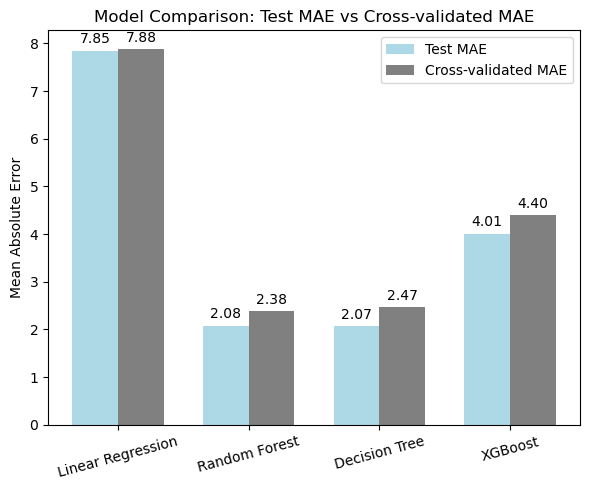

In [65]:
# Model names
models = ['Linear Regression', 'Random Forest', 'Decision Tree', 'XGBoost']

# Values
test_mae = [7.85, 2.08, 2.07, 4.01]
cv_mae = [7.88, 2.38, 2.47, 4.40]

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.bar(x - width/2, test_mae, width, label='Test MAE', color='lightblue')
rects2 = ax.bar(x + width/2, cv_mae, width, label='Cross-validated MAE', color='grey')

# Labels and title
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Model Comparison: Test MAE vs Cross-validated MAE')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Show values on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

We avaluated the predictive performance of four machine learning models to forecast bike availability: Linear Regression, Random Forest, Decision Tree, and XGBoost.

We are considering: MAE (Mean Absolute Error), which tell us the average absolute difference between predicted and actual bike availability and R2 (Coefficient of Determination) indicates how much of the variability in the target variable is explained by the model. Closer to 1 is better. 

Linear Regression performed poorly (High MAE(7.85, very low R2 (0.06)), Random Forest performed best overall (good combination, with lower test MAE(2.08 and highest R2 (0.90)), Decision Tree performed slightly worse than Random Forest (Similar MAE (2.07) but lower R2 (0.84)), and XGBoost performed decently, but not as well as Random Forest (MAE (4.01), R2(0.71)). 